In [14]:
import h5py
import numpy as np
import allel
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

In [15]:
archaic_filepath = "data/LCT_MCM6.h5"
archaic_data = h5py.File(archaic_filepath, mode='r')
# Extract the genotypes.
heli_gt = allel.GenotypeArray(archaic_data['all/calldata/GT'][:])
# Extract the variable positions array.
heli_pos = allel.SortedIndex(archaic_data['all/variants/POS'][:])
# Extract the samples array.
heli_samps = np.array([samp.decode() for samp in archaic_data['all/samples'][:]])
heli_samps

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
       'NA21144'], dtype='<U7')

In [16]:
# load the hdf5 file
tgp_MCM_data = h5py.File('data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5', mode='r')
# extract genotypes
tgp_MCM_gt = allel.GenotypeArray(tgp_MCM_data['all/calldata/GT'][:])
# extract the variable positions array
tgp_MCM_pos = allel.SortedIndex(tgp_MCM_data['all/variants/POS'][:])
# extract the samples array
tgp_MCM_samps = np.array([samp.decode() for samp in tgp_MCM_data['all/samples'][:]])


In [17]:
# load the hdf5 file
tgp_LCT_data = h5py.File('data/tgp_var_sites_no_aa_calls_chr2_LCT.h5', mode='r')
# extract genotypes
tgp_LCT_gt = allel.GenotypeArray(tgp_LCT_data['calldata/GT'][:])
# extract the variable positions array
tgp_LCT_pos = allel.SortedIndex(tgp_LCT_data['variants/POS'][:])
# extract the samples array
tgp_LCT_samps = np.array([samp.decode() for samp in tgp_LCT_data['samples'][:]])
tgp_LCT_data['calldata/GT']

<HDF5 dataset "GT": shape (1377, 2504, 2), type "|i1">

In [18]:
metadata = pd.read_csv("data/tgp_meta_info.txt", 
                       header=None, 
                       names=["sample", "population", "super_population"],
                       sep='\t')
samples_df = pd.DataFrame({"sample": tgp_LCT_samps})

merged = samples_df.merge(
    metadata[["sample","population","super_population"]],
    on="sample",
    how="left"
)
print(merged.head())

    sample population super_population
0  HG00096        GBR              EUR
1  HG00097        GBR              EUR
2  HG00099        GBR              EUR
3  HG00100        GBR              EUR
4  HG00101        GBR              EUR


In [19]:
species_id = [sample.split('.')[0] for sample in heli_samps]


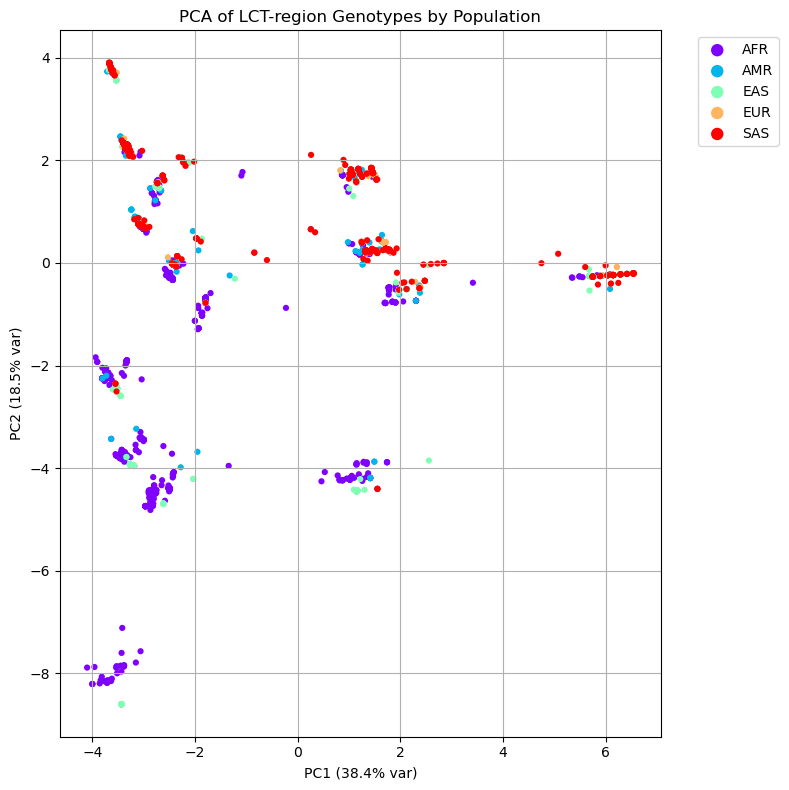

In [22]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# your merged DataFrame already has a “population” column aligned with tgp_LCT_samps
pops = merged["super_population"].values

# build the genotype matrix and run PCA (same as before)
gt = tgp_MCM_gt[:]            # (V, N, 2)
ac = gt.sum(axis=2)           # (V, N)
geno = ac.T                   # (N, V)
pca = PCA(n_components=2)
coords = pca.fit_transform(geno)

# get the unique populations and a qualitative colormap
unique_pops = np.unique(pops)
cmap = plt.get_cmap("rainbow", len(unique_pops))

plt.figure(figsize=(8,8))
for i, pop in enumerate(unique_pops):
    mask = (pops == pop)
    plt.scatter(
        coords[mask, 0],
        coords[mask, 1],
        s=20,
        color=cmap(i),
        label=pop,
        edgecolor="none"
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA of LCT-region Genotypes by Population")
plt.legend(markerscale=2, bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


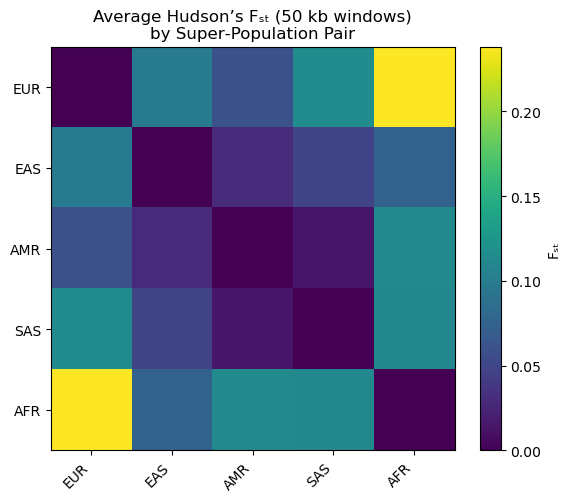

In [ ]:
fn = 'data/tgp_var_sites_no_aa_calls_chr2_MCM6.h5'
with h5py.File(fn, 'r') as f:
    gt = allel.GenotypeArray(f['all/calldata/GT'][:])
    pos = allel.SortedIndex(f['all/variants/POS'][:])
    samples = np.array([s.decode() for s in f['all/samples'][:]])

meta = pd.read_csv(
    "data/tgp_meta_info.txt",
    sep='\t',
    header=None,
    names=["sample", "population", "super_population"]
)
df = pd.DataFrame({'sample': samples})
df = df.merge(meta, on='sample', how='left')

super_pops = df['super_population'].unique()
pop_idx = {
    pop: np.where(df['super_population'] == pop)[0]
    for pop in super_pops
}

ac_all = gt.count_alleles()
maf = np.minimum(ac_all[:,0], ac_all[:,1]) / ac_all.sum(axis=1)
keep = maf >= 0.05
gt = gt.compress(keep, axis=0)
pos = pos[keep]

wsize = 50_000
start, stop = pos.min(), pos.max()
bins = np.arange(start, stop + wsize, wsize)
n_win = len(bins) - 1

pairs = list(combinations(super_pops, 2))
fst_sq = np.zeros((len(super_pops), len(super_pops)), dtype=float)
for pop1, pop2 in pairs:
    i = np.where(super_pops == pop1)[0][0]
    j = np.where(super_pops == pop2)[0][0]

    ac1 = gt.take(pop_idx[pop1], axis=1).count_alleles()
    ac2 = gt.take(pop_idx[pop2], axis=1).count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)

    widx = np.digitize(pos, bins) - 1  
    
    num_w = np.bincount(widx, weights=num, minlength=n_win)
    den_w = np.bincount(widx, weights=den, minlength=n_win)
    with np.errstate(invalid='ignore', divide='ignore'):
        fst_win = num_w / den_w
    fst_mean = np.nanmean(fst_win)

    fst_sq[i, j] = fst_sq[j, i] = fst_mean

np.fill_diagonal(fst_sq, 0.0)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(fst_sq, vmin=0, vmax=fst_sq.max(), cmap='viridis')
ax.set_xticks(np.arange(len(super_pops)))
ax.set_yticks(np.arange(len(super_pops)))
ax.set_xticklabels(super_pops, rotation=45, ha='right')
ax.set_yticklabels(super_pops)
ax.set_title("Average Hudson’s Fₛₜ (50 kb windows)\nby Super‐Population Pair")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Fₛₜ")
plt.tight_layout()
plt.show()